By Alan Picucci

In this notebook, the aim is to use evolutionary algorithms to find the best possible Tic-Tac-Toe player. Given the nature of Tic-Tac-Toe, specifically that the player to make the first move can be sure to avoid losing by following certain strategies, the goal will be to find the player that loses the fewest games possible, rather than the one with most wins.

I would like to note that my approaches were inspired from the following paper: Hochmuth, Gregor. (2003). "On the genetic evolution of a perfect Tic-tac-toe strategy."

However, the implemented code is entirely my own as they did not provide theirs.



# Setting up the board representation

In this project, I will represent the board as a 3x3 numpy array that can take the following values: 


*   0 representing an empty space
*   1 representing an "X"
*   2 representing an "O"

Moreover, I will always assume that the player with "X" goes first.

The genome of each Player in the population will be a list representing a move to play in each board configuration. However, given that Tic-Tac-Toe has 3^9 possible configurations and few moves which are actually good, a brute search of this space would not be a wise approach. Instead, we will exploit the fact that the vast majority of these configurations are redundant. In fact, each board configuration is essentially equivalent to 7 other board configurations, obtained by applying some simple transformations to the board: 


*   Rotation by 90°, or 180°, or 270°
*   Flipping horizontally or vertically
*   Rotating by 90° and flipping horizontally or vertically

They are equivalent in the sense that the same move should be played in each case (the move is the same after applying the appropriate transformation). Moreover, some of the board configurations are not even possible to achieve, as they would only occur if we broke the rules (for example, playing after one player has already won or the same player playing twice in a row).

We use both of these facts in the following way: among the viable board configurations, we essentially partition them into equivalence classes and choose one board from each class to act as a "base board". In practice, this is done by computing a unique hash for each board and then selecting the board in each equivalence class which has the smallest hash value.

Finally, a Player's gene will then be a list representing the move to play for each base board only.

In [1]:
import os 
import random
import numpy as np
from itertools import product
from collections import deque
import matplotlib.pyplot as plt
import pickle

In [5]:
#Define the functions needed to transform the board (to find all symmetric boards)

def rotate90(board):
    """
    Rotate the board 90 degrees clockwise.
    """
    return np.array([list(reversed(x)) for x in zip(*board)])

def rotate180(board):
    """
    Rotate the board 180 degrees clockwise.
    """
    return rotate90(rotate90(board))

def rotate270(board):
    """
    Rotate the board 270 degrees clockwise.
    """
    return rotate90(rotate90(rotate90(board)))

def flip_horizontal(board):
    """
    Reflect the board along the horizontal axis.
    """
    return board[::-1]

def flip_vertical(board):
    """
    Reflect the board along the vertical axis.
    """
    return np.array([row[::-1] for row in board])

def base_case_and_transformation(board):
    """
    Find the symmetric board with the smallest hash value, and return the transformation used to obtain it.
    """
    # Define the possible transformations
    transformations = [
        ('rotate90', rotate90),
        ('rotate180', rotate180),
        ('rotate270', rotate270),
        ('flip_horizontal', flip_horizontal),
        ('flip_vertical', flip_vertical),
        ('rotate90_flip_horizontal', lambda x: rotate90(flip_horizontal(x))),
        ('rotate90_flip_vertical', lambda x: rotate90(flip_vertical(x)))
    ]
    
    # Apply each transformation to the board and calculate its hash
    boards_hashes = [(transformation[0], transformation[1](board), hash_board(transformation[1](board))) 
                     for transformation in transformations]
    
    # Include the original board (with no transformation)
    boards_hashes.append(('original', board, hash_board(board)))
    
    # Find the board with the smallest hash
    smallest_hash_transformation, smallest_hash_board, smallest_hash = min(boards_hashes, key=lambda x: x[2])
    
    return smallest_hash_board, int(smallest_hash), smallest_hash_transformation

def apply_inverse_transform(board, transformation):
    """
    Apply the inverse transformation to a board. 
    The inputs are the transformed board and the transformation used to achieve it.
    """
    # Define the inverse transformations
    inverse_transformations = {
        'rotate90': rotate270,
        'rotate180': rotate180,
        'rotate270': rotate90,
        'flip_horizontal': flip_horizontal,
        'flip_vertical': flip_vertical,
        'rotate90_flip_horizontal': lambda x: flip_horizontal(rotate270(x)),
        'rotate90_flip_vertical': lambda x: flip_vertical(rotate270(x)),
        'original': lambda x: x  # if the board is the original, we don't need to do anything
    }

    if transformation not in inverse_transformations:
        raise ValueError(f"Unknown transformation: {transformation}")
    
    return inverse_transformations[transformation](board)

def invert_move(move, transformation):
    """
    Given a move in the base board, find the move in the original board
    """
    # Define the inverse transformations
    inverse_transformations = {
        'rotate90': rotate270,
        'rotate180': rotate180,
        'rotate270': rotate90,
        'flip_horizontal': flip_horizontal,
        'flip_vertical': flip_vertical,
        'rotate90_flip_horizontal': lambda x: flip_horizontal(rotate270(x)),
        'rotate90_flip_vertical': lambda x: flip_vertical(rotate270(x)),
        'original': lambda x: x  # if the board is the original, we don't need to do anything
    }

    if transformation not in inverse_transformations:
        raise ValueError(f"Unknown transformation: {transformation}")
    
    board = np.zeros(9)
    board[move]=1
    board=board.reshape(3,3)
    return np.where(apply_inverse_transform(board, transformation).reshape(9) == 1)[0][0]


#The function is treating each cell of the tic-tac-toe board as a ternary (base 3) digit. 
#This function uniquely converts a board configuration into an integer
def hash_board(board):
    """
    Compute a unique hash for a given tic-tac-toe board using numpy operations.
    
    'Empty cells are 0, 'X' is 1, 'O' is 2. The entire board is treated as a single 9-digit number in base-3.
    """
    power_values = np.power(3, np.arange(9))
    return np.dot(board.reshape(-1), power_values)

def print_board(board):
    """
    Given a board in its np array state, print the board
    """
    symbols = [' ', 'X', 'O']
    print('\n-----')
    for i in range(3):
        for j in range(3):
            print(symbols[board.astype(int)[i][j]], end='|' if j != 2 else '')
        print('\n-----' if i != 2 else '')

def hash_to_board(i, output=False):
    """
    Given a hash, return the board associated to that hash
    """
    board = np.zeros(9)
    for j in range(9):
        board[j] = i % 3
        i //= 3
    board=board.reshape(3,3)
    if output:
        print_board(board)
    return board


In [6]:
def check_winner(board):
    """
    Check if there is a winner in the current board and, if so, return the winner
    """
    for i in range(3):
        if board[i][0] == board[i][1] == board[i][2] != 0:  # Check rows
            return board[i][0]
        if board[0][i] == board[1][i] == board[2][i] != 0:  # Check columns
            return board[0][i]
    if board[0][0] == board[1][1] == board[2][2] != 0:  # Check main diagonal
        return board[0][0]
    if board[0][2] == board[1][1] == board[2][0] != 0:  # Check other diagonal
        return board[0][2]
    return 0  # No winner

def is_valid_board(board):
    """
    Check the validity of a board
    """
    x_count = np.sum(board == 1)
    o_count = np.sum(board == 2)
    if not (0 <= x_count - o_count <= 1):
        return False  #One player has played too many moves

    winner = check_winner(board)
    if x_count - o_count == 1 and winner == 2:
        return False  # There's a winner but there were moves after that
    
    if x_count - o_count == 0 and winner == 1:
        return False  # There's a winner but there were moves after that

    if winner:
        board_copy = np.copy(board)
        board_copy[board == winner] = 0
        if check_winner(board_copy):  # If there's still a winner after removing the first one, it's invalid
            return False

    return True

def generate_all_possible_boards():
    """
    Generate all possible configurations of the tic-tac-toe board.
    """
    # There are 3^9 possible states of the tic tac toe board: 0, 1, 2 for each of the 9 cells
    return [np.array(board).reshape(3,3) for board in product([0, 1, 2], repeat=9)]


# Initialize an empty list for the base hashes and base boards
base_hashes = []
base_boards = []

# Generate all possible boards
all_boards = generate_all_possible_boards()

# Loop through each board
for board in all_boards:
    # Check if the board is valid
    if is_valid_board(board):
        # Find the base case and its hash for the valid board
        smallest_hash_board, smallest_hash, smallest_hash_transformation = base_case_and_transformation(board)
        
        # If the hash of the base case is not in base_hashes, add it
        if smallest_hash not in base_hashes:
            base_hashes.append(smallest_hash)
            base_boards.append(smallest_hash_board)


In [7]:
len(base_hashes)

765

So we have managed to go from 3^9 configurations to 765 configurations! This significantly simplifies the strategy representation.

# Defining the genetic algorithm

In this section, I define the genetic algorithm that will be used. The following table summarizes the key features of the algorithm.

| Element | Description |
|---------|-------------|
| Representation | Integer list of length 765. Each integer represents a legal move to be made in each base board |
| Fitness evaluation | Each Player plays every possible game that they can encounter given their strategy. The fitness of a player is then the percentage of these games that they do not lose |
| Replication | With a probability of 0.1, replicate a player in the new population (but apply mutation) |
| Parent selection | For the player going first, I used tournament selecion with k=10. However, for the other players, the search gets easily stuck in local maxima when using tournament selection. Meanwhile, when using roulette wheel selection its fitness fluctuates and does not show an upward trend. To try and address this, I've decided to "mix" the two selection criteria. I start with tournament selection using k=10, and after 15 generations with no improvements I switch to roulette wheel selection (probabilities computed after rescaling the fitnesses according to their mean and standard deviation). Hopefully, this can help us escape local maxima.  |
| Recombination | Initially, two parents produce one child as follows: copy genes from parent 1 until we hit the crossover rate (0.15 in this case). Then, start copying from parent 2 until we hit crossover rate again, and so on. After this initial implementation, I allowed the option for parents to produce two children: the second child goes through the same process as the first, but with the parents' roles inverted.
| Mutation | Each element of the genome has a probability of 0.001 of being changed to another random (but legal) move.  Moreover, to find the second player and overall best player, I double the mutation rate after 15 generations in a row without improvements (up to a threshold of 0.5) until we find a new best solution.| 
| Survivor selection | New population is 3 times old population. Remove the worst members of the new population. Also, we preserve the best player from the previous generation. |

I would like to remark that other configurations were also tested before this one. For example, I had defined another fitness metric before: each player played against all other players in the population, and the percentage of these games that were not lost was returned. However, this did not make much sense as the quality of the players would mostly not be good and the fitness value would then not accurately represent the actual quality of each player.

In [8]:
class Player:
    def __init__(self):
        #Initialize each entry of the genes list as a move that can be played (where board==0, so where there are empty spaces) in each base board configuration
        self.genes = [np.random.choice(np.where(board.reshape(9) == 0)[0]) if np.any(board == 0) else None for board in base_boards] 
        self.hash_to_value = dict(zip(base_hashes, self.genes)) #This is a dictionary that maps hash values to entries in the genes list. 
        self.F = 0

    def get_move(self, board):
        """
        Get the player's move given a board configuration.
        """
        smallest_hash_board, smallest_hash, smallest_hash_transformation = base_case_and_transformation(board)
        move = self.hash_to_value[smallest_hash]
        move = invert_move(move, smallest_hash_transformation)
        return move

class SimpleGA:
    def __init__(self, n_generations=500, population_size=100, mutation_rate=0.001, crossover_rate=0.15, replication_rate=0.1, k = 10, player_id=None):
        self.pop = [Player() for _ in range(population_size)]
        self.n_generations = n_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.replication_rate = replication_rate
        self.k = k
        self.player_id = player_id 
        #Player_id can be 1, 2 or None. These values indicate, respectively, that we are searching for a no-loss strategy for a player who plays first, a player who plays second or a player who can do both. 

    #roulette wheel selection with relative fitness
    def __roulette_wheel_selection(self):
        # Compute the mean and standard deviation of the scores
        scores = np.array([s.F for s in self.pop])
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        # If standard deviation is zero (all fitnesses are the same), each individual has an equal chance of being selected
        if std_score == 0:
            probabilities = [1/len(scores) for _ in self.pop]
        else:
            # Rescale the scores and compute the sum of rescaled scores
            rescaled_scores = (scores - mean_score) / std_score
            # Shift rescaled_scores so they are all non-negative
            min_score = min(rescaled_scores)
            if min_score < 0:
                rescaled_scores -= min_score  # subtracting a negative number is equivalent to adding its absolute value

            population_score = np.sum(rescaled_scores)

            # Computes the probability for each individual
            probabilities = [s/population_score for s in rescaled_scores]

        # Selects one individual based on the computed probabilities
        selected = np.random.choice(self.pop, p=probabilities)

        return selected

    # Tournament selection
    def __tournament_selection(self):

        # first random selection
        selected = np.random.choice(self.pop)

        # random selection of the remaining k-1 individuals
        for s in np.random.choice(self.pop, self.k-1, replace=False):
            # check if better (e.g. perform a tournament)
            if s.F > selected.F:
                selected = s
        return selected


    def crossover(self, parent1, parent2, two_children=False):
        """
        Copy genes from parent 1 until we hit the crossover rate (0.15 in this case). 
        Then, start copying from parent 2 until we hit crossover rate again, and so on.
        """
        child1 = Player()
        child2 = Player()
        gene_source1 = parent1  # We start copying genes from parent1
        gene_source2 = parent2
        for i in range(len(self.pop[0].genes)):
            if random.random() < self.crossover_rate:  
                # If crossover event occurs, we switch the gene source
                gene_source1 = parent1 if gene_source1 == parent2 else parent2
                gene_source2 = parent1 if gene_source2 == parent2 else parent2
            child1.genes[i] = gene_source1.genes[i]
            child2.genes[i] = gene_source2.genes[i]
        if two_children:
            return child1, child2
        else:
           return [child1]


    def mutate(self, individual):
        """
        Each element of the genome has a probability of 0.001 of being changed to another random (but legal) move
        """
        for i in range(len(self.pop[0].genes)):
            if random.random() < self.mutation_rate:
                individual.genes[i] = np.random.choice(np.where(base_boards[i].reshape(9) == 0)[0]) if np.any(base_boards[i] == 0) else None

    def fitness_function(self, player):
        """
        A given Player plays every possible game that they can encounter given their strategy and we return
        the percentage of games they do not lose. This process has been implemented using a breadth first search
        algorithm. If we are looking for a player who exclusively goes first or second, we only play games where 
        that occurs. Otherwise, they play both roles.
        """
        n_wins = 0
        n_draws = 0
        n_losses = 0
        n_errors = 0
        total_games = 0
        player_ids=[1, 2] if self.player_id is None else [self.player_id]
        for player_id in player_ids:
            queue = deque([(np.zeros((3,3)), 1)])
            while queue:
                board, next_player = queue.popleft()
                if next_player == player_id:
                    move = player.get_move(board)
                    new_board = board.copy()
                    new_board[move//3][move%3] = player_id
                    winner = check_winner(new_board)
                    if winner == 0 and np.any(new_board == 0):
                        queue.append((new_board, 3 - next_player))
                    else:
                        if np.sum(new_board==2)==5:
                          n_errors+=1
                        if winner == player_id:
                            n_wins += 1
                            total_games += 1 #won
                        if winner == 0 and not np.any(new_board == 0):
                            n_draws += 1
                            total_games += 1 #draw
                        if winner != player_id and winner != 0:
                            n_losses += 1 #loss
                            total_games +=1
                else:
                    for move in range(9):
                        if board[move//3][move%3] == 0:
                            new_board = board.copy()
                            new_board[move//3][move%3] = next_player
                            winner = check_winner(new_board)
                            if winner == 0 and np.any(new_board == 0):
                                queue.append((new_board, 3 - next_player))
                            else:
                                if np.sum(new_board==2)==5:
                                  n_errors+=1
                                if winner == player_id:
                                    n_wins +=1
                                    total_games += 1 #won
                                if winner == 0 and not np.any(new_board == 0):
                                    n_draws +=1
                                    total_games += 1 #draw
                                if winner != player_id and winner != 0:
                                    n_losses += 1 #loss
                                    total_games +=1
        #print("Total games: ", total_games,"\nWins: ", n_wins, "\nDraws: ", n_draws, "\nLosses: ", n_losses, "\nErrors: ", n_errors)         
        return 1-(n_losses / total_games)



    # Function to update fitness of each individual
    def __update_fitness(self, pop):
        for s in pop:
            s.F = self.fitness_function(s)

    def run(self, selection="RWS", two_children=False, increase_mutation=False):
        best_fitnesses = []
        best, best_score = self.pop[0], self.pop[0].F
        self.select = None
        n_stuck=0

        if selection == "TS":
            self.__select = self.__tournament_selection
        
        elif selection == "RWS":
            self.__select = self.__roulette_wheel_selection
        
        else:
            print("Error! The available selection strategies are 'TS' and 'RWS'.")
            return -1

        for gen in range(self.n_generations):
            self.__update_fitness(self.pop)

            new_population = []
            while len(new_population) < 3*len(self.pop):
                if random.random() < self.replication_rate:
                    replica=self.__select()
                    self.mutate(replica)
                    new_population.append(replica)
                else:
                    parent1 = self.__select()
                    parent2 = self.__select()
                    children = self.crossover(parent1, parent2, two_children)
                    for child in children:
                        self.mutate(child)
                        if len(new_population) < 3*len(self.pop):
                            new_population.append(child)
            self.__update_fitness(new_population)
            if gen>0 and best_curr.F>max([s.F for s in new_population]):
                new_population[0]=best_curr #preserve best
            new_population.sort(key=lambda s: s.F, reverse=True)
            self.pop = new_population[:len(self.pop)]

            best_curr = max(self.pop, key=lambda s: s.F)
            worst_curr = min(self.pop, key=lambda s: s.F)
            best_fitnesses.append(best_curr.F)

            # evaluate all candidate solutions (i.e., individuals) in the population
            print("Generation", gen, "best fitness", best_curr.F, " worst fitness", worst_curr.F)
            if best_curr.F == 1:
                print("Found no-loss strategy!")
                best=best_curr
                best_score=best_curr.F
                return best, best_score, best_fitnesses
            # check for the new best individual
            if best_curr.F > best_score:
                best = best_curr
                best_score = best_curr.F       
                n_stuck=0
                self.mutation_rate=0.001
                if increase_mutation:
                    self.__select = self.__tournament_selection
                print("New best individual found",best_curr,"(Gen. %3d)" %gen)
            else:
                n_stuck +=1
            if n_stuck==15 and increase_mutation==True:
                if self.mutation_rate<0.5:
                    self.mutation_rate *= 2 #Try to escape local maxima
                self.__select = self.__roulette_wheel_selection
                n_stuck=0
        return best, best_score, best_fitnesses

# Running the genetic algorithm

In this section, I run the genetic algorithm. First, I run it to find the best player who always plays first. As we'll see below, this is significantly easier than finding the one who only plays second or one who can play either role.

## Finding best player who plays first

In [46]:
# Run GA with roulette wheel selection
ga = SimpleGA(n_generations=500, population_size=200, player_id=1)
best, best_score, best_fitnesses = ga.run(selection="TS")

print("Optimisation completed using tournament selection! Best fitness: ", best_score)

Generation 0 best fitness 0.9452054794520548  worst fitness 0.7177700348432056
New best individual found <__main__.Player object at 0x1154a6400> (Gen.   0)
Generation 1 best fitness 0.9795918367346939  worst fitness 0.7238805970149254
New best individual found <__main__.Player object at 0x1153675b0> (Gen.   1)
Generation 2 best fitness 0.9795918367346939  worst fitness 0.7165354330708662
Generation 3 best fitness 0.9795918367346939  worst fitness 0.7220216606498195
Generation 4 best fitness 0.9795918367346939  worst fitness 0.7132352941176471
Generation 5 best fitness 0.9795918367346939  worst fitness 0.7162162162162162
Generation 6 best fitness 0.9795918367346939  worst fitness 0.7242798353909465
Generation 7 best fitness 0.9795918367346939  worst fitness 0.7206896551724138
Generation 8 best fitness 0.9795918367346939  worst fitness 0.722007722007722
Generation 9 best fitness 0.9795918367346939  worst fitness 0.7114754098360656
Generation 10 best fitness 0.9795918367346939  worst fitn

Generation 100 best fitness 0.9821428571428571  worst fitness 0.7215189873417722
Generation 101 best fitness 0.9821428571428571  worst fitness 0.7209302325581395
Generation 102 best fitness 0.9821428571428571  worst fitness 0.7263513513513513
Generation 103 best fitness 0.9821428571428571  worst fitness 0.7159763313609467
Generation 104 best fitness 0.9821428571428571  worst fitness 0.7242647058823529
Generation 105 best fitness 0.9821428571428571  worst fitness 0.7235494880546075
Generation 106 best fitness 0.9821428571428571  worst fitness 0.7215189873417722
Generation 107 best fitness 0.9821428571428571  worst fitness 0.7213622291021672
Generation 108 best fitness 0.9821428571428571  worst fitness 0.7252396166134185
Generation 109 best fitness 0.9821428571428571  worst fitness 0.7183098591549295
Generation 110 best fitness 0.9821428571428571  worst fitness 0.7261410788381742
Generation 111 best fitness 0.9821428571428571  worst fitness 0.7178571428571429
Generation 112 best fitness 

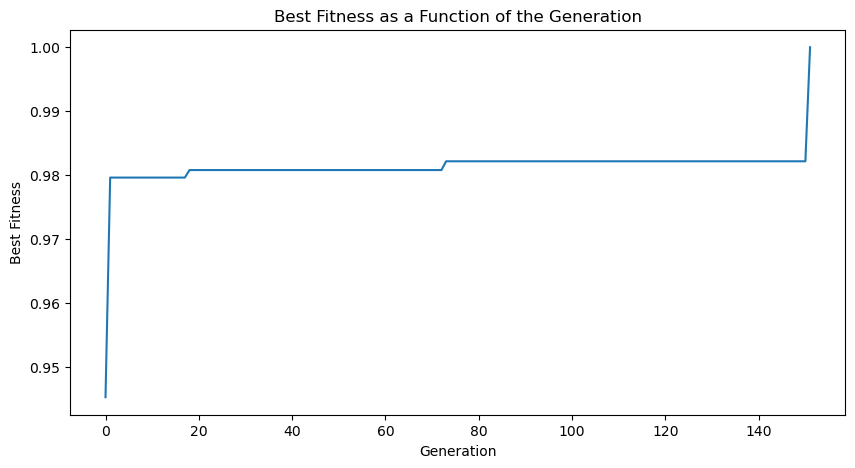

In [47]:
# Plot the best fitness as a function of the generation
plt.figure(figsize=(10, 5))
plt.plot(best_fitnesses)
plt.title('Best Fitness as a Function of the Generation')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [48]:
# Save the object
with open('/Users/alanpicucci/Desktop/Evolutionary Algorithms/Project/best_player_first.pkl', 'wb') as output:
    pickle.dump(best, output, pickle.HIGHEST_PROTOCOL)


We managed to find a player that never loses if they start!

## Finding best player who plays second

In [70]:
# Run GA 
ga = SimpleGA(n_generations=500, population_size=200, player_id=2)
best, best_score, best_fitnesses = ga.run(selection="TS", two_children=True, increase_mutation=True)

print("Optimisation completed using Tournament selection with increasing mutation! Best fitness: ", best_score)


Generation 0 best fitness 0.6651532349602725  worst fitness 0.43494423791821557
New best individual found <__main__.Player object at 0x13d7c5430> (Gen.   0)
Generation 1 best fitness 0.6651532349602725  worst fitness 0.44313725490196076
Generation 2 best fitness 0.6651532349602725  worst fitness 0.4449818621523579
Generation 3 best fitness 0.6651532349602725  worst fitness 0.4484076433121019
Generation 4 best fitness 0.6651532349602725  worst fitness 0.4381625441696113
Generation 5 best fitness 0.6651532349602725  worst fitness 0.4428399518652226
Generation 6 best fitness 0.6651532349602725  worst fitness 0.44205495818399043
Generation 7 best fitness 0.6793802145411204  worst fitness 0.446242774566474
New best individual found <__main__.Player object at 0x13cb339d0> (Gen.   7)
Generation 8 best fitness 0.6793802145411204  worst fitness 0.4405997693194925
Generation 9 best fitness 0.6793802145411204  worst fitness 0.4435196195005945
Generation 10 best fitness 0.6793802145411204  worst f

Generation 97 best fitness 0.7538644470868014  worst fitness 0.4424173318129989
Generation 98 best fitness 0.7538644470868014  worst fitness 0.4375757575757576
Generation 99 best fitness 0.7538644470868014  worst fitness 0.4369426751592357
Generation 100 best fitness 0.7538644470868014  worst fitness 0.4340320591861899
Generation 101 best fitness 0.7538644470868014  worst fitness 0.44483985765124556
Generation 102 best fitness 0.7538644470868014  worst fitness 0.43457382953181267
Generation 103 best fitness 0.7538644470868014  worst fitness 0.4390243902439024
Generation 104 best fitness 0.7538644470868014  worst fitness 0.4371108343711083
Generation 105 best fitness 0.7538644470868014  worst fitness 0.4448484848484848
Generation 106 best fitness 0.7538644470868014  worst fitness 0.44550898203592815
Generation 107 best fitness 0.7538644470868014  worst fitness 0.43995243757431624
Generation 108 best fitness 0.7538644470868014  worst fitness 0.4477791116446579
Generation 109 best fitness

Generation 197 best fitness 0.8120978120978121  worst fitness 0.4378843788437884
Generation 198 best fitness 0.8120978120978121  worst fitness 0.4382022471910112
Generation 199 best fitness 0.8120978120978121  worst fitness 0.44550898203592815
Generation 200 best fitness 0.8120978120978121  worst fitness 0.44375772558714466
Generation 201 best fitness 0.8120978120978121  worst fitness 0.4407364787111623
Generation 202 best fitness 0.8120978120978121  worst fitness 0.438489646772229
Generation 203 best fitness 0.8120978120978121  worst fitness 0.43861740166865315
Generation 204 best fitness 0.8120978120978121  worst fitness 0.441696113074205
Generation 205 best fitness 0.8120978120978121  worst fitness 0.4436183395291202
Generation 206 best fitness 0.8120978120978121  worst fitness 0.44474034620505987
Generation 207 best fitness 0.8120978120978121  worst fitness 0.4395857307249712
Generation 208 best fitness 0.8120978120978121  worst fitness 0.4443021766965429
Generation 209 best fitnes

Generation 298 best fitness 0.8120978120978121  worst fitness 0.43970767356881857
Generation 299 best fitness 0.8120978120978121  worst fitness 0.4423305588585018
Generation 300 best fitness 0.8120978120978121  worst fitness 0.43945068664169784
Generation 301 best fitness 0.8120978120978121  worst fitness 0.4388398486759143
Generation 302 best fitness 0.8120978120978121  worst fitness 0.4361078546307151
Generation 303 best fitness 0.8120978120978121  worst fitness 0.4435994930291508
Generation 304 best fitness 0.8120978120978121  worst fitness 0.44252163164400493
Generation 305 best fitness 0.8120978120978121  worst fitness 0.4389965792474344
Generation 306 best fitness 0.8120978120978121  worst fitness 0.4426229508196722
Generation 307 best fitness 0.8120978120978121  worst fitness 0.4412855377008653
Generation 308 best fitness 0.8120978120978121  worst fitness 0.4418331374853114
Generation 309 best fitness 0.8120978120978121  worst fitness 0.44387096774193546
Generation 310 best fitn

Generation 398 best fitness 0.8210526315789474  worst fitness 0.43937575030012
Generation 399 best fitness 0.8210526315789474  worst fitness 0.4464944649446494
Generation 400 best fitness 0.8210526315789474  worst fitness 0.44214372716199757
Generation 401 best fitness 0.8210526315789474  worst fitness 0.4383561643835616
Generation 402 best fitness 0.8210526315789474  worst fitness 0.43829296424452135
Generation 403 best fitness 0.8210526315789474  worst fitness 0.4378698224852071
Generation 404 best fitness 0.8210526315789474  worst fitness 0.4409857328145266
Generation 405 best fitness 0.8210526315789474  worst fitness 0.4390243902439024
Generation 406 best fitness 0.8210526315789474  worst fitness 0.4438006952491309
Generation 407 best fitness 0.8210526315789474  worst fitness 0.44106463878326996
Generation 408 best fitness 0.8210526315789474  worst fitness 0.4504283965728274
Generation 409 best fitness 0.8210526315789474  worst fitness 0.4392735527809307
Generation 410 best fitness

Generation 499 best fitness 0.8210526315789474  worst fitness 0.4394141145139814
Optimisation completed using roulette wheel selection! Best fitness:  0.8210526315789474


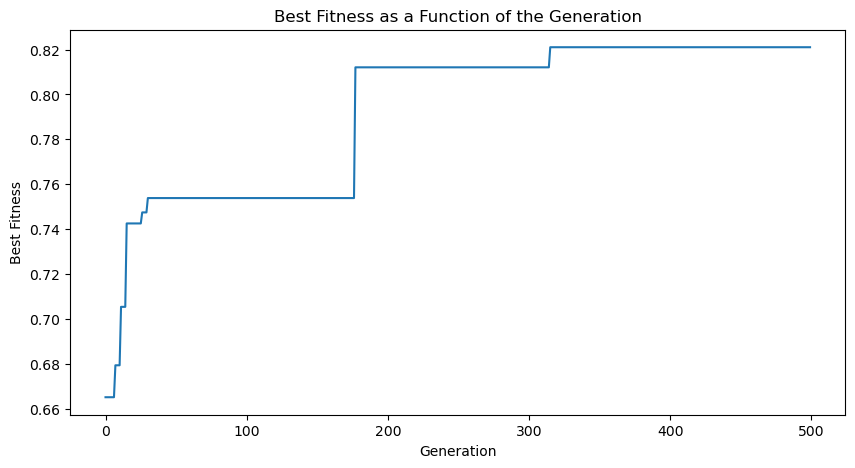

In [79]:
# Plot the best fitness as a function of the generation
plt.figure(figsize=(10, 5))
plt.plot(best_fitnesses)
plt.title('Best Fitness as a Function of the Generation')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [80]:
# Save the object
with open('/Users/alanpicucci/Desktop/Evolutionary Algorithms/Project/best_player_second.pkl', 'wb') as output:
    pickle.dump(best, output, pickle.HIGHEST_PROTOCOL)


In this case, the algorithm got stuck in a local maxima and could not escape, despite the adaptive mutation and selection scheme. The best player has a 82.1% no-loss rate. It is unclear whether more generations or different population sizes could prove beneficial: as the training time is quite significant, it is very time consuming to execute many runs to find optimal hyperparameters, though ideally this should be done.

## Finding best player overall

In [20]:
# Run GA 
ga = SimpleGA(n_generations=500, population_size=200, player_id=None)
best, best_score, best_fitnesses = ga.run(selection="TS", two_children=True, increase_mutation=True)

print("Optimisation completed using Tournament selection with increasing mutation! Best fitness: ", best_score)


Generation 0 best fitness 0.6630648330058939  worst fitness 0.5041322314049587
New best individual found <__main__.Player object at 0x11009bb80> (Gen.   0)
Generation 1 best fitness 0.7136404697380307  worst fitness 0.502410800385728
New best individual found <__main__.Player object at 0x11a5ac6d0> (Gen.   1)
Generation 2 best fitness 0.7136404697380307  worst fitness 0.502116850127011
Generation 3 best fitness 0.7136404697380307  worst fitness 0.5066037735849056
Generation 4 best fitness 0.7136404697380307  worst fitness 0.5033050047214354
Generation 5 best fitness 0.7136404697380307  worst fitness 0.49914965986394555
Generation 6 best fitness 0.7136404697380307  worst fitness 0.4986400725294651
Generation 7 best fitness 0.7136404697380307  worst fitness 0.4985888993414863
Generation 8 best fitness 0.7136404697380307  worst fitness 0.5033947623666344
Generation 9 best fitness 0.7136404697380307  worst fitness 0.5004269854824936
Generation 10 best fitness 0.7136404697380307  worst fitn

Generation 99 best fitness 0.7712486883525709  worst fitness 0.5021987686895338
Generation 100 best fitness 0.7712486883525709  worst fitness 0.5013054830287207
Generation 101 best fitness 0.7712486883525709  worst fitness 0.5046728971962617
Generation 102 best fitness 0.7712486883525709  worst fitness 0.5013032145960035
Generation 103 best fitness 0.7712486883525709  worst fitness 0.5013333333333334
Generation 104 best fitness 0.7712486883525709  worst fitness 0.5021872265966754
Generation 105 best fitness 0.7712486883525709  worst fitness 0.506631299734748
Generation 106 best fitness 0.7712486883525709  worst fitness 0.5026929982046678
Generation 107 best fitness 0.7712486883525709  worst fitness 0.5029888983774551
Generation 108 best fitness 0.7712486883525709  worst fitness 0.49763033175355453
Generation 109 best fitness 0.7712486883525709  worst fitness 0.49488054607508536
Generation 110 best fitness 0.7712486883525709  worst fitness 0.501432664756447
Generation 111 best fitness 0

Generation 201 best fitness 0.7712486883525709  worst fitness 0.4995408631772268
Generation 202 best fitness 0.7712486883525709  worst fitness 0.5009041591320073
Generation 203 best fitness 0.7712486883525709  worst fitness 0.49624060150375937
Generation 204 best fitness 0.7712486883525709  worst fitness 0.4995458673932789
Generation 205 best fitness 0.7712486883525709  worst fitness 0.5032021957913998
Generation 206 best fitness 0.7712486883525709  worst fitness 0.49823943661971826
Generation 207 best fitness 0.7712486883525709  worst fitness 0.5032377428307123
Generation 208 best fitness 0.7712486883525709  worst fitness 0.49955476402493326
Generation 209 best fitness 0.7712486883525709  worst fitness 0.5041322314049587
Generation 210 best fitness 0.7712486883525709  worst fitness 0.5018214936247722
Generation 211 best fitness 0.7712486883525709  worst fitness 0.5056768558951965
Generation 212 best fitness 0.7712486883525709  worst fitness 0.5044483985765125
Generation 213 best fitne

Generation 302 best fitness 0.7857142857142857  worst fitness 0.5017699115044247
Generation 303 best fitness 0.7857142857142857  worst fitness 0.4981916817359855
Generation 304 best fitness 0.7857142857142857  worst fitness 0.5
Generation 305 best fitness 0.7857142857142857  worst fitness 0.5059797608095676
Generation 306 best fitness 0.7857142857142857  worst fitness 0.4990272373540856
Generation 307 best fitness 0.7857142857142857  worst fitness 0.5063063063063062
Generation 308 best fitness 0.7857142857142857  worst fitness 0.500909090909091
Generation 309 best fitness 0.7857142857142857  worst fitness 0.5009074410163339
Generation 310 best fitness 0.7857142857142857  worst fitness 0.4981851179673321
Generation 311 best fitness 0.7857142857142857  worst fitness 0.5102404274265361
Generation 312 best fitness 0.7857142857142857  worst fitness 0.5012875536480687
Generation 313 best fitness 0.7857142857142857  worst fitness 0.5034825870646766
Generation 314 best fitness 0.78571428571428

Generation 405 best fitness 0.7857142857142857  worst fitness 0.4995417048579285
Generation 406 best fitness 0.7857142857142857  worst fitness 0.5004397537379068
Generation 407 best fitness 0.7857142857142857  worst fitness 0.5021240441801189
Generation 408 best fitness 0.7857142857142857  worst fitness 0.5008605851979346
Generation 409 best fitness 0.7857142857142857  worst fitness 0.49592760180995477
Generation 410 best fitness 0.7857142857142857  worst fitness 0.49954669084315506
Generation 411 best fitness 0.7857142857142857  worst fitness 0.5031222123104371
Generation 412 best fitness 0.7857142857142857  worst fitness 0.5049954586739328
Generation 413 best fitness 0.7857142857142857  worst fitness 0.49955869373345096
Generation 414 best fitness 0.7857142857142857  worst fitness 0.49678604224058764
Generation 415 best fitness 0.7857142857142857  worst fitness 0.5012987012987014
Generation 416 best fitness 0.7857142857142857  worst fitness 0.5082266910420475
Generation 417 best fitn

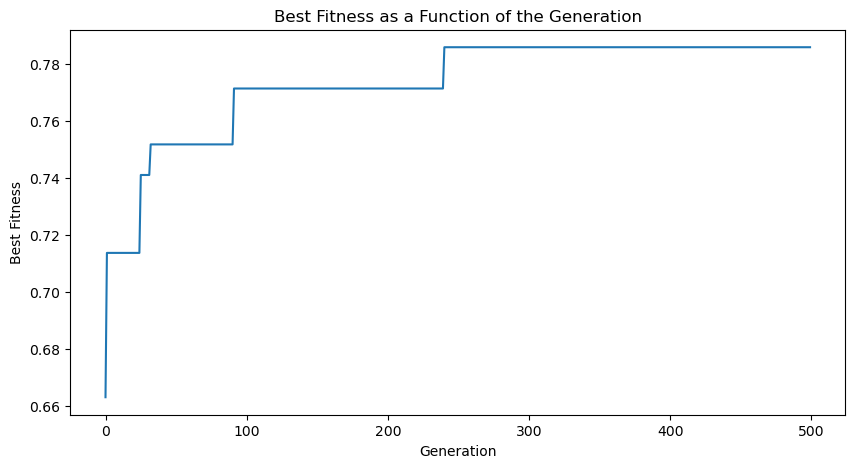

In [22]:
import matplotlib.pyplot as plt

# Plot the best fitness as a function of the generation
plt.figure(figsize=(10, 5))
plt.plot(best_fitnesses)
plt.title('Best Fitness as a Function of the Generation')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.show()

In [23]:
# Save the object
with open('/Users/alanpicucci/Desktop/Evolutionary Algorithms/Project/best_player_overall.pkl', 'wb') as output:
    pickle.dump(best, output, pickle.HIGHEST_PROTOCOL)


Just like for the past player, this search gets stuck and cannot escape local maxima. The best player has a 78.6% no-loss rate.

# Playing against the best bots

In this final section, I have defined some functions that allow users to play against the best bot(s) that were produced by the genetic algorithm.

In [11]:
def valid_move(board, move):
    """
    Checks if a move is valid
    """
    return board[move//3][move%3] == 0

def get_player_move(board):
    """
    Gets the user to input a move
    """
    move = int(input("Your move (0-8): "))
    while move < 0 or move >= 9 or board[move//3][move%3] != 0:
        move = int(input("Invalid move. Choose another move (0-8): "))
    return move

def play_against_bot(computer, player_id=1):
    """
    Allows the user to play against a Player (input as "computer"). Player_id indicates whether the user goes first or second.
    """
    board = np.zeros((3,3))
    bot_id=3-player_id
    current=1
    while True:
        if current==player_id:
            # Your move
            print_board(board)
            move = get_player_move(board)
            board[move//3][move%3] = player_id
            # Check if you won
            if check_winner(board):
                print("You won!")
                break
            current=3-player_id
        else:
            # Best player's move
            move = computer.get_move(board)
            while not valid_move(board, move):
                move = np.random.randint(9)
            board[move//3][move%3] = bot_id
            # Check if best player won
            if check_winner(board):
                print_board(board)
                print("The AI won!")
                break
            current=3-bot_id
        if not np.any(board==0):
            print("Draw!")
            break

    print_board(board)

## Play against the best first player

In [2]:
cwd=os.getcwd()

First, we load the Player instance that was found by the GA. This Player was optimised to play first.
Note: the cells to load the players require that the .pkl files are in the same directory as the Jupyter Notebook.

In [3]:
cwd+'/best_player_first.pkl'

'/Users/alanpicucci/Desktop/Evolutionary Algorithms/Project/best_player_first.pkl'

In [9]:
# Load the object
with open(cwd+'/best_player_first.pkl', 'rb') as file:
    best_player_first = pickle.load(file)

Here, the bot goes first while the player goes second. In theory, the bot should never lose. You can give it your best shot though! You can also change the 2 to a 1 in the below function to play first, in which case the bot probably won't do very well.

In [13]:
play_against_bot(best_player_first, player_id=2)


-----
 | | 
-----
 |X| 
-----
 | | 
Your move (0-8): 6

-----
 | |X
-----
 |X| 
-----
O| | 
Your move (0-8): 5

-----
 |X|X
-----
 |X|O
-----
O| | 
Your move (0-8): 0

-----
O|X|X
-----
X|X|O
-----
O| | 
Your move (0-8): 7
Draw!

-----
O|X|X
-----
X|X|O
-----
O|O|X


## Play against the best second player

First, we load the Player instance that was found by the GA. This Player was optimised to play second.

In [14]:
# Load the object
with open(cwd+'/best_player_second.pkl', 'rb') as file:
    best_player_second = pickle.load(file)

Here, the bot goes second while the player goes first. This bot can actually lose, since the GA couldn't find a no-loss strategy for starting second. I've noticed you can win quite easily by starting from the center cell.

In [55]:
play_against_bot(best_player_second, player_id=1)


-----
 | | 
-----
 | | 
-----
 | | 
Your move (0-8): 0

-----
X| | 
-----
 |O| 
-----
 | | 
Your move (0-8): 8

-----
X| | 
-----
 |O| 
-----
 |O|X
Your move (0-8): 1

-----
X|X| 
-----
 |O|O
-----
 |O|X
Your move (0-8): 2
You won!

-----
X|X|X
-----
 |O|O
-----
 |O|X


## Play against the overall best player

First, we load the Player
instance that was found by the GA. This Player was optimised to play in general, not just starting first or second.

In [41]:
# Load the object
with open(cwd+'/best_player_overall.pkl', 'rb') as file:
    best_player_overall = pickle.load(file)

You can choose whether to play first or second in the function below, just change 'player_id' accordingly. This bot actually seems to play much worse than the individual strategies above.

In [44]:
play_against_bot(best_player_overall, player_id=2)


-----
 | | 
-----
 | | 
-----
X| | 
Your move (0-8): 0

-----
O| | 
-----
X| | 
-----
X| | 
Your move (0-8): 1

-----
O|O| 
-----
X| | 
-----
X|X| 
Your move (0-8): 2
You won!

-----
O|O|O
-----
X| | 
-----
X|X| 


# Future work

The next steps would undoubtedly be to try and render the code more efficient, allowing for a more time efficient search of the hyperparameter space as well as testing different selection methods.